# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
from PIL import Image
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

# Define Pytorch Dataset

In [2]:
class CardsDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

## Initalize Dataset

In [3]:
dataset = CardsDataset(data_dir=r"C:\Users\razaf\Project1\Playing_Cards\train")

In [4]:
len(dataset)

7624

8


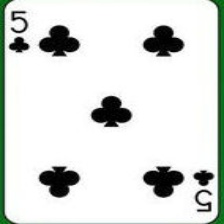

In [5]:
image, label = dataset[1234]

print(label)

image

### Dictionary defining target cards with folders

In [6]:
data_dir = r"C:\Users\razaf\Project1\Playing_Cards\train"
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
#print(target_to_class)

In [7]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = CardsDataset(data_dir, transform)

In [8]:
image, _ = dataset[99]

image.shape

torch.Size([3, 128, 128])

In [9]:
#iterate through dataset
for image, label in dataset:
    break

## Dataloading

- Batch the dataset for faster training

In [10]:
#Define dataloader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [11]:
##iterate through dataloader
for images, labels in dataloader:
    break

#images.shape, labels.shape

In [12]:
labels

tensor([41, 23,  1, 15,  0, 39, 39,  5, 44,  2, 39, 48,  3,  3,  3, 35, 10, 17,
        28,  3, 14, 49, 51, 40,  4, 40, 47, 48, 37, 38, 31, 22])

## Define Model with Pytorch

In [13]:
class SimpleCardClassifer(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifer, self).__init__()
        # Define model basis and features
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )
    
    def forward(self, x):
        # Initialize both parts with return, to be used
        x = self.features(x)
        output = self.classifier(x)
        return output

In [14]:
model = SimpleCardClassifer(num_classes=53)

In [15]:
example_out = model(images)
example_out.shape

torch.Size([32, 53])

#Follows as expected, batch_size=32, num_classes=53

## Training Loop

In [16]:
#Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
#Loss function
criterion = nn.CrossEntropyLoss()

In [17]:
criterion(example_out, labels)
#print(example_out.shape, labels.shape)

tensor(4.0766, grad_fn=<NllLossBackward0>)

### Datasets
Training, validation and testing datasets

In [18]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = r"C:\Users\razaf\Project1\Playing_Cards\train"
valid_folder = r"C:\Users\razaf\Project1\Playing_Cards\valid"
test_folder = r"C:\Users\razaf\Project1\Playing_Cards\test"

train_dataset = CardsDataset(train_folder, transform=transform)
val_dataset = CardsDataset(valid_folder, transform=transform)
test_dataset = CardsDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Training Loop
Defining the training loop
- Epoch's - Training iterations performed on the whole training set
- Step's - Size of a batch of data

2 variables that must be defined
- Optimizer - `Adam` will be used here, simple and effective
- Loss Function - Goal that training loop will optimize for

In [19]:
#Training loop
num_epochs = 5
training_all_losses, val_all_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCardClassifer(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    training_loss = running_loss / len(train_loader.dataset)
    training_all_losses.append(training_loss)
    
    # Validation Cycle
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            
    val_loss = running_loss / len(val_loader.dataset)
    val_all_losses.append(val_loss)
    print(f"Epoch #{epoch+1}/{num_epochs} - Train loss: {round(training_loss, 5)}, Validation loss: {round(val_loss, 5)}")

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch #1/5 - Train loss: 1.6174, Validation loss: 0.45738


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch #2/5 - Train loss: 0.57213, Validation loss: 0.19541


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch #3/5 - Train loss: 0.34513, Validation loss: 0.19584


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch #4/5 - Train loss: 0.2331, Validation loss: 0.10406


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch #5/5 - Train loss: 0.19963, Validation loss: 0.17718


### Visualize decrease in loss

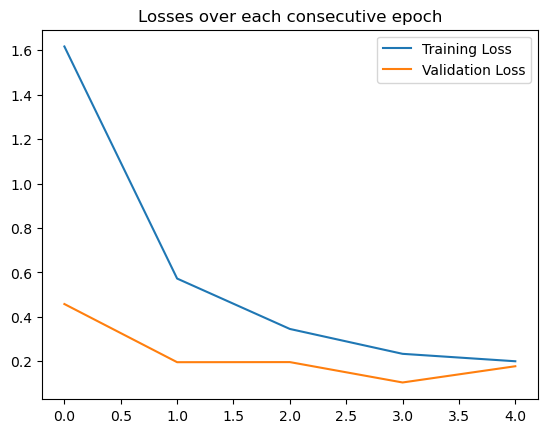

In [20]:
plt.plot(training_all_losses, label="Training Loss")
plt.plot(val_all_losses, label="Validation Loss")
plt.title("Losses over each consecutive epoch")
plt.legend()

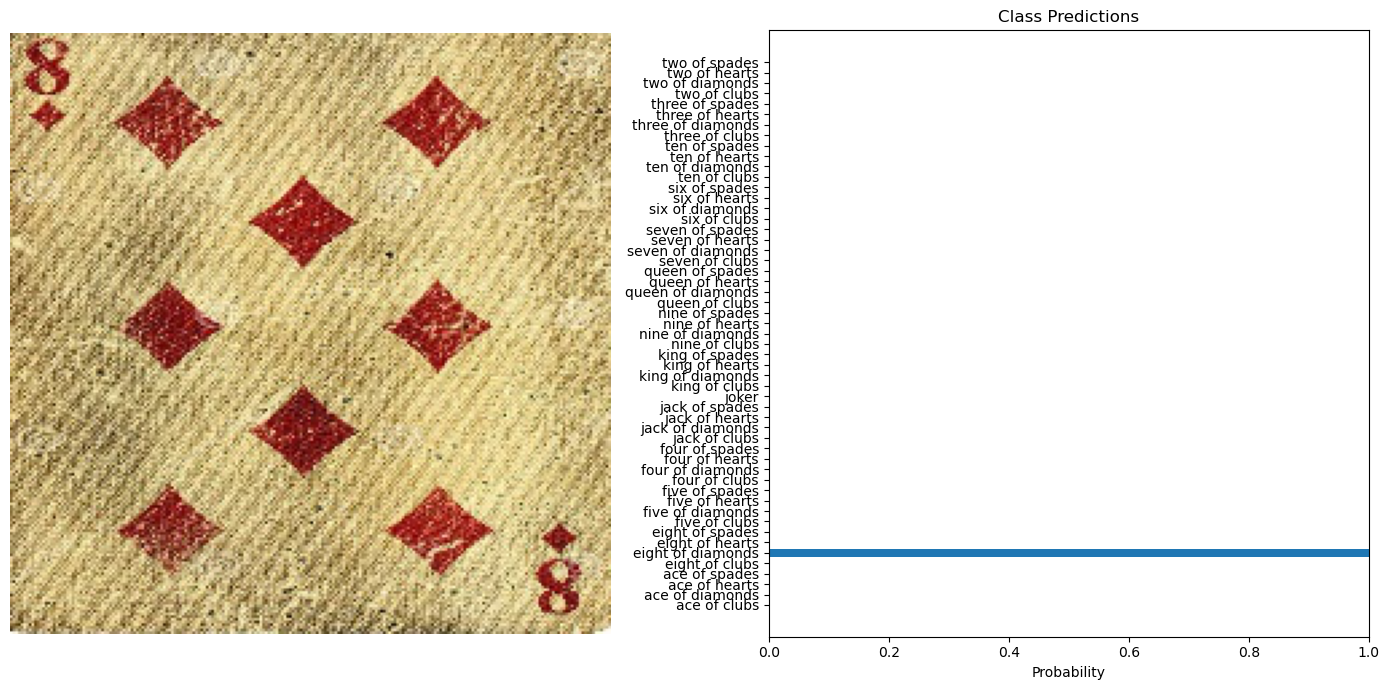

In [21]:
# Load and preprocess image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = r"C:\Users\razaf\Project1\Playing_Cards\test\eight of diamonds\3.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes 
visualize_predictions(original_image, probabilities, class_names)

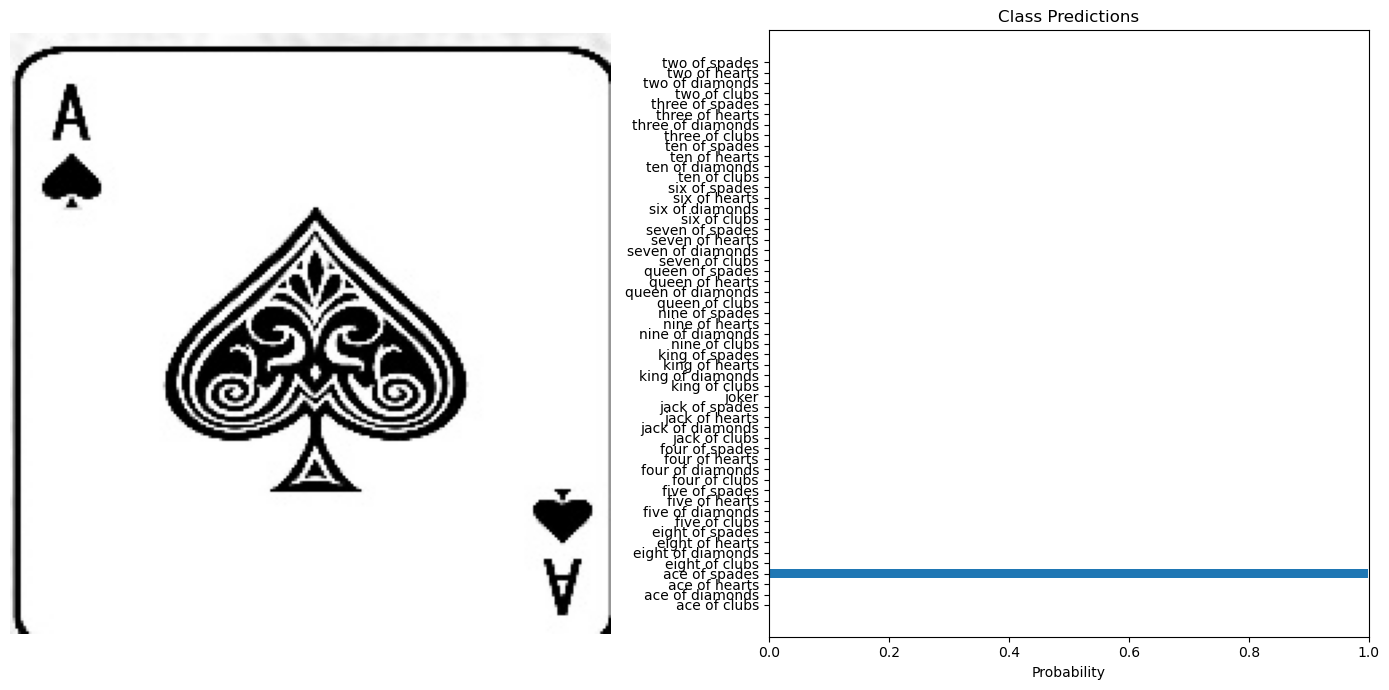

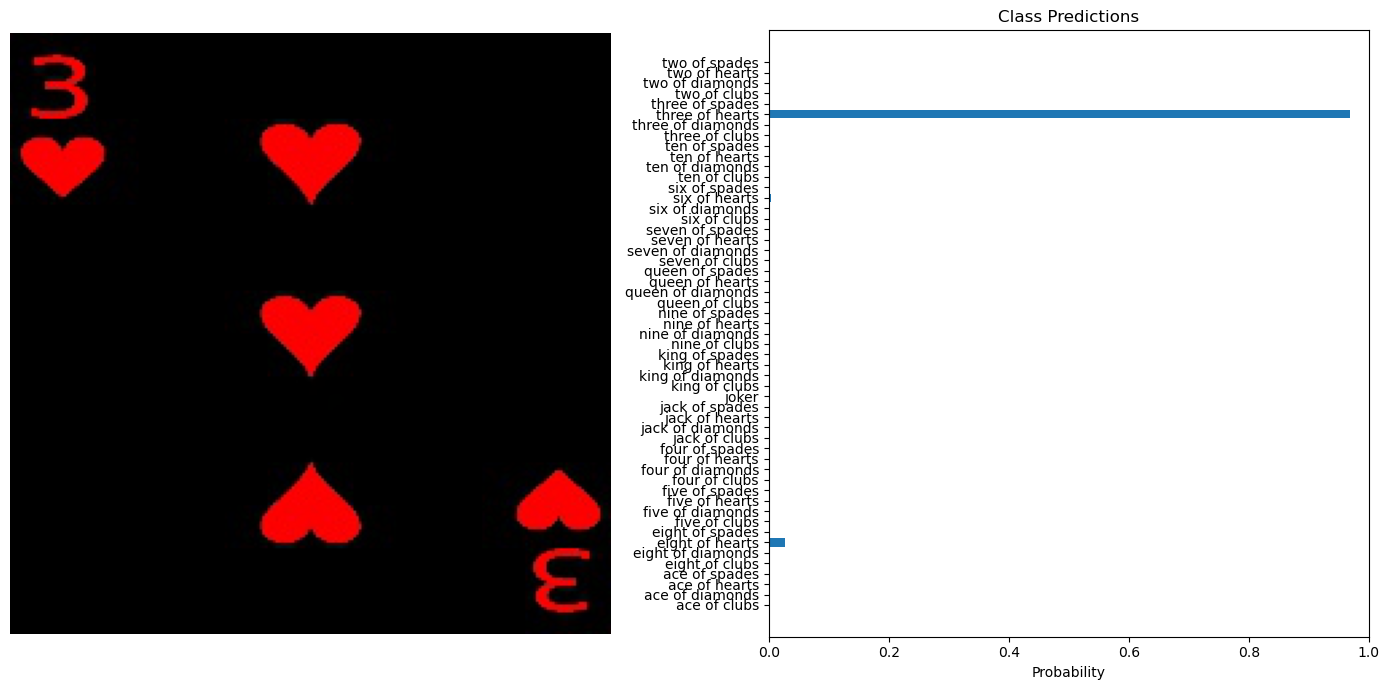

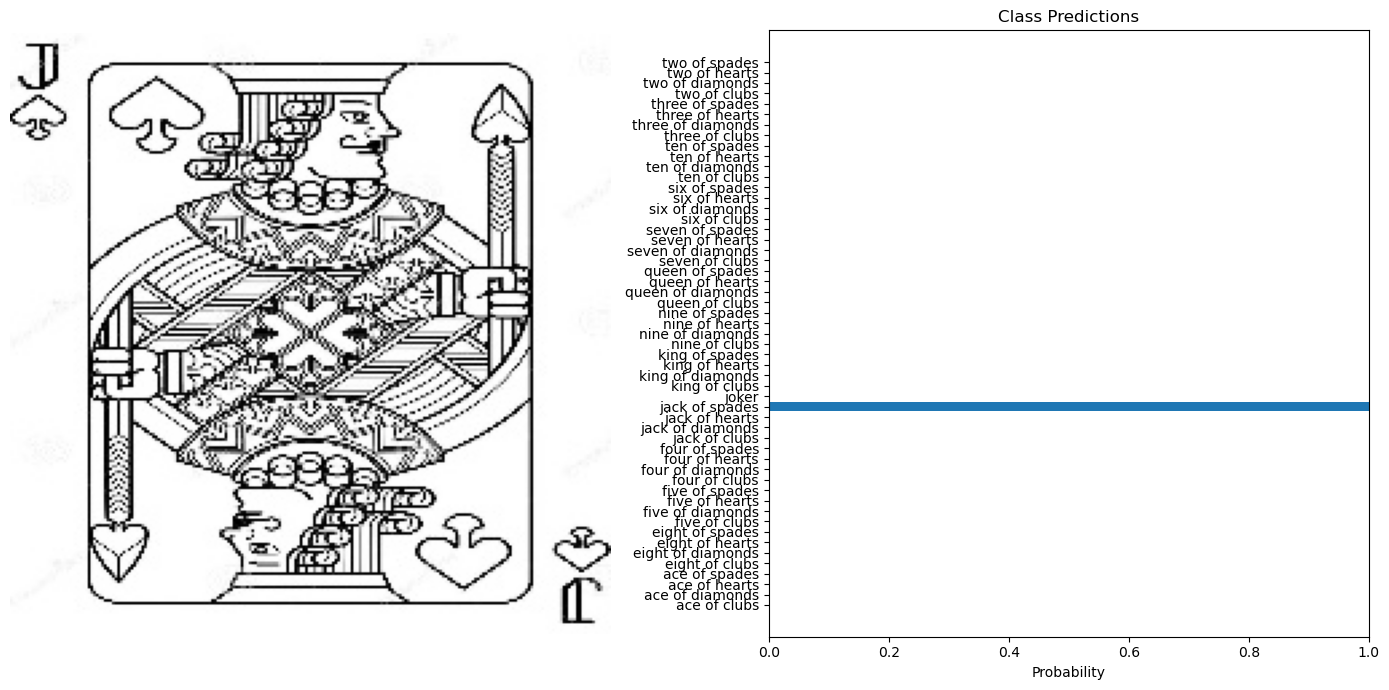

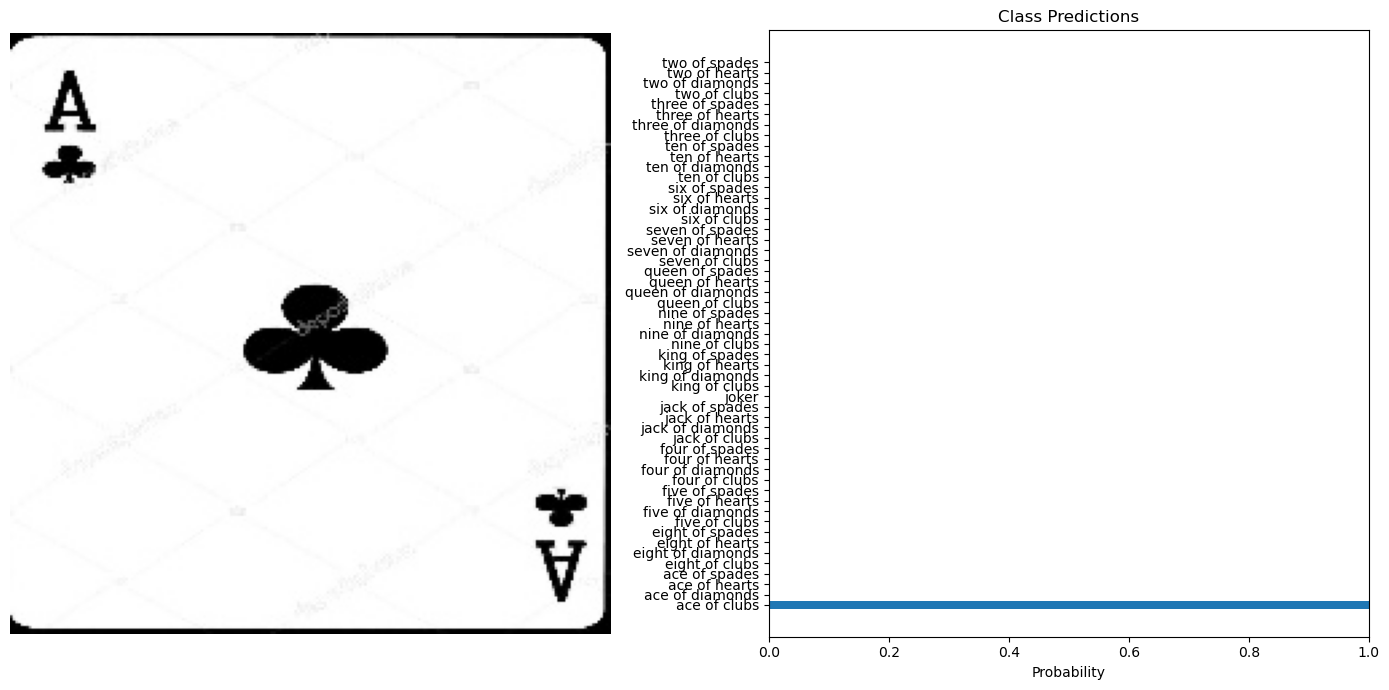

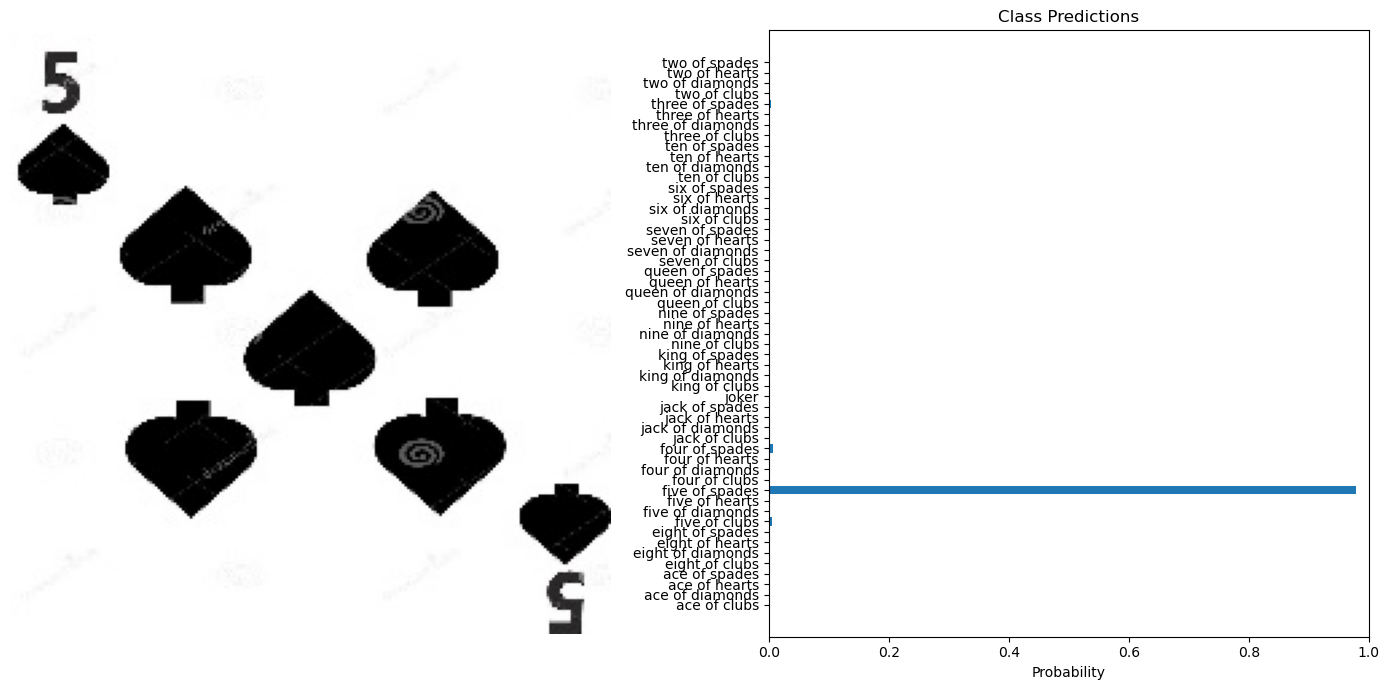

In [22]:
testing_images = glob(r"C:\Users\razaf\Project1\Playing_Cards\test\*\*")

rand_tests = np.random.choice(testing_images, 5)

for example in rand_tests:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes 
    visualize_predictions(original_image, probabilities, class_names)

In [23]:
#print(np.random.choice(testing_images, 1))

In [24]:
testing_images = glob(r"C:\Users\razaf\Project1\Playing_Cards\test\*\*")

accuracy_vals = []
card_lst_seen = []
for example in testing_images:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)
    
    max_val = max(probabilities)
    card = class_names[np.where(probabilities == max_val)[0][0]]
    
    if card in card_lst_seen:
        accuracy_vals[-1].append(max_val)
    else:
        card_lst_seen.append(card)
        accuracy_vals.append([card, max_val])

In [25]:
cards_accuracy = {}
for card in accuracy_vals:
    cards_accuracy[card[0]] = np.average(card[1:])

In [27]:
cards = list(cards_accuracy.keys())
values = list(cards_accuracy.values())

print("The average accuracy of prediction is", np.average(values))

The average accuracy of prediction is 0.95108384


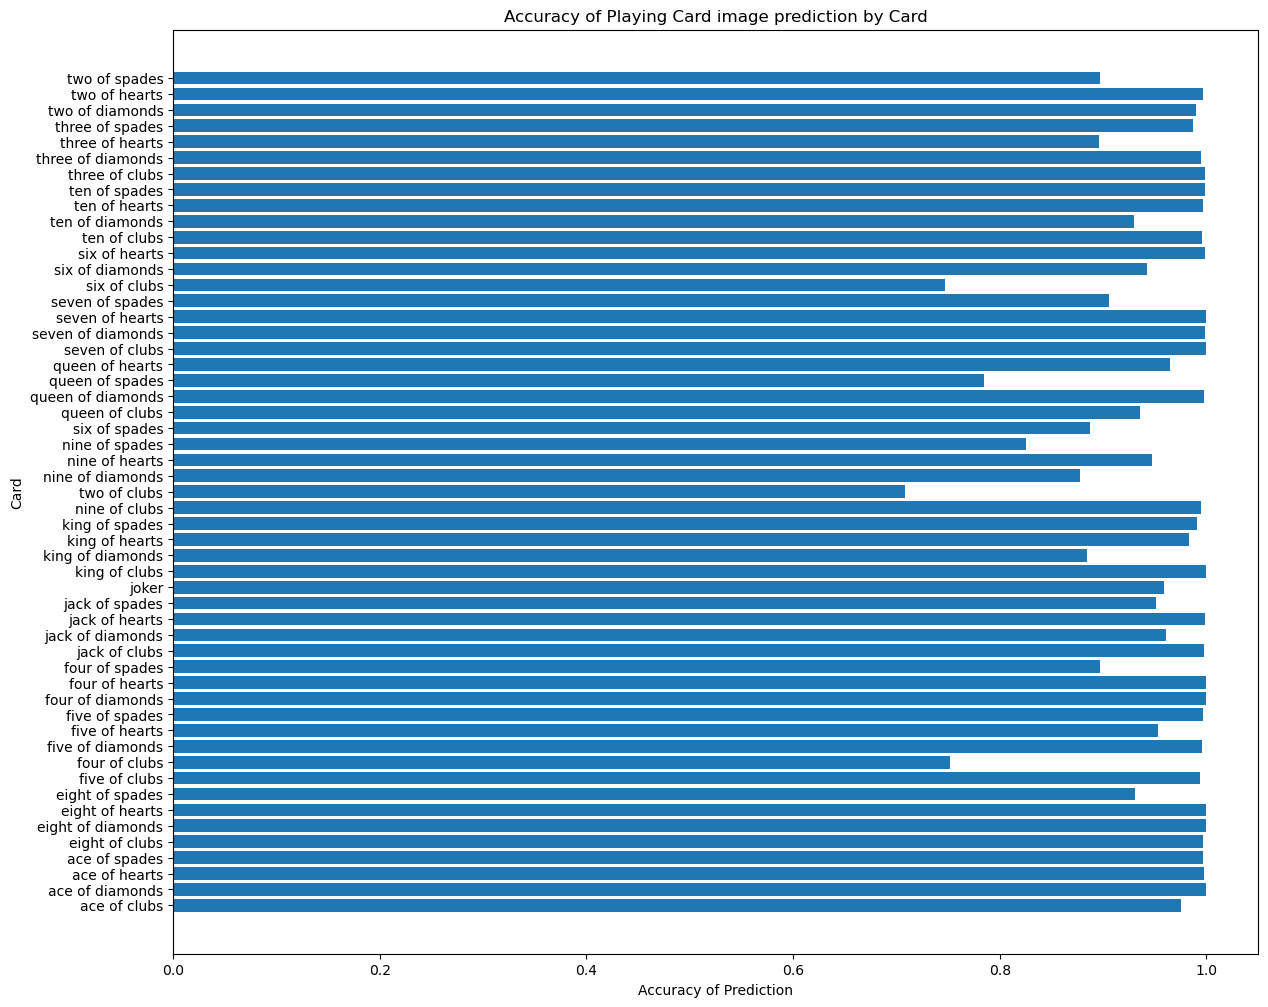

In [28]:
fig = plt.figure(figsize = (14, 12))

# Create Bar Plot
plt.barh(cards, values)

plt.ylabel("Card")
plt.xlabel("Accuracy of Prediction")
plt.title("Accuracy of Playing Card image prediction by Card")
plt.show()